In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import csv
from datetime import datetime, timedelta
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow.keras import regularizers
from tensorflow import keras

In [ ]:

def acc_prec_rec(TP, FN, TN, FP):
    # accuracy = proportion of true results among the total number of cases examined
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    
    # precision = what proportion of predicted Positives is truly positive
    print('TP',TP)
    print('FP',FP)
    if TP ==0:
        if FP ==0:
            precision = 0
    else:
        precision = (TP)/(TP+FP)
    
    #recall = what proportion of actual Positives is correctly classified (= True positive rate)
    # = sensitivity
    if TP ==0:
        if FN ==0:
            recall = 0
        else:
            recall = (TP)/(TP+FN)
    else: 
        recall = (TP)/(TP+FN)
    #specificity (=False positive rate)
    if TN ==0:
        if FP ==0:
            specificity =0
        else:
            specificity = (TN)/(TN + FP)
    else:
        specificity = (TN)/(TN + FP)
    
    # F1 score: number between 0 and 1, harmonic mean of precision and recall
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2*(precision*recall)/(precision + recall)
    
    confusion_matrix = [[TP, FP],[FN,TN]]
    confusion_matrix = np.array(confusion_matrix)/np.array(confusion_matrix).sum(axis = 1)
    
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('sensitivity (recall): ', recall)
    print('specificity: ', specificity)
    print('F1: ',F1)
    return accuracy, precision, recall, specificity, F1, confusion_matrix    
    
scale_min = 0
scale_max = 1
def scaling(df,df_min,df_max,scale_min,scale_max):
    df_std = (df-df_min) / (df_max-df_min)
    df_scaled = df_std* (scale_max - scale_min)+scale_min
    return df_scaled

def scaling_reverse(df,df_min,df_max,scale_min,scale_max):
    df_scaled_reverse = (df-scale_min)/(scale_max-scale_min)*(df_max-df_min)+df_min
    return df_scaled_reverse    

In [3]:
def compute_dust_events(dataframe):
    
# result from the neural network is a dataframe with a column "sde_event" with numbers between 0 and 1
    dataframe1 = list()
    k2 = list()
    # search for all indices, where the value is bigger than 0.5
    for i in range(len(dataframe['sde_event'])):
        if dataframe['sde_event'].loc[i]>=0.5:
            k2.append(i)
    
    # see if 4 consecutive numbers are in the list, if this is the case append the index in the list
    k1 = list()
    for el in k2:
        if el+3 in k2:
            if el+2 in k2:
                if el+1 in k2:
                    k1.append(el)        
    sde_event_1s = np.zeros_like(dataframe['sde_event'].values)
    # for all the indices in the event list, specify them to be a dust event
    for j in k1:
        sde_event_1s[j:j+4]=np.array([1,1,1,1])
    # add this list in the dataframe
    dataframe['sde_event_predicted']=sde_event_1s
    return dataframe

In [4]:
def number_noevents_dates(dataframe, event_name, event_col):
    dataframe[event_col]=0
    num = 1
    # find the dates, where there are some dust events and number them 
    for k,v in dataframe.groupby((dataframe[event_name].shift() !=dataframe[event_name]).cumsum()):
   #     print(f'[group{k}]')
   #     print(v[event_name])
   #     print('\n')
    
        if v[event_name].all() ==0:
            dataframe[event_col].loc[v.index]=num
           # print(v.index)
            num = num+1
            
    return dataframe

In [5]:
def number_noevents_data(dataframe, noevent_col, event_name, event_col):
    # number that dust events in the dataframe
    num_nosde = 1
    num_sde = 1
    dataframe[noevent_col]=0
    dataframe[event_col]=0
    
    for k,v in dataframe.groupby((dataframe[event_name].shift() !=dataframe[event_name]).cumsum()):
        if v[event_name].all() ==0:
            dataframe[noevent_col].loc[v.index]=num_nosde
            num_nosde = num_nosde+1
        if v[event_name].all() ==1:
            dataframe[event_col].loc[v.index]=num_sde
            num_sde = num_sde+1
    return dataframe
    

In [6]:
def metric_sde(dates, qoi_val_pred):
    count_sde = 0
    count_nosde = 0
    dust_event_nrs = dates['sde_event_nr'].unique()[1:]
    nodust_event_nrs = dates['nosde_event_nr'].unique()[1:]

    for ev in (dust_event_nrs):
        #print('dust_event_number: ',ev)
        ev_index = dates[dates['sde_event_nr']==ev].index
        #print(qoi_val_pred['sde_event_predicted'].loc[ev_index].sum())
        if qoi_val_pred['sde_event_predicted'].loc[ev_index].sum() >0:
            count_sde = count_sde+1

    for noev in (nodust_event_nrs):
        #print('nodust_event_number: ',noev)
        noev_index = dates[dates['nosde_event_nr']==noev].index
        #print(qoi_val_pred['sde_event_predicted'].loc[noev_index].sum())
        if qoi_val_pred['sde_event_predicted'].loc[noev_index].sum() >0:
            count_nosde = count_nosde
        else:
            count_nosde = count_nosde +1
    N_sde_truth = len(dust_event_nrs) 
    N_nosde_truth = len(nodust_event_nrs)
    TP = count_sde+1
    FN = N_sde_truth - TP
    TN = count_nosde
    FP = N_nosde_truth - count_nosde
    N_sde_pred = qoi_val_pred['sde_event_predicted_nr'].max()
    N_nosde_pred = qoi_val_pred['nosde_event_predicted_nr'].max()

   # print('true number sde: ', N_sde_truth )
   # print('true number nosde: ', N_nosde_truth)
   # print('predicted number sde: ',N_sde_pred )
    
   # print('predicted number nosde: ', N_nosde_pred)
    print('True positive: ', TP)
    print('False negative: ',FN)
    print('True negative: ', TN)
    print('False positive: ',FP)

    result = [N_sde_truth, N_nosde_truth, N_sde_pred, N_nosde_pred, TP, FN, TN, FP]
    
    return result


In [7]:
df_results = pd.DataFrame()
rowdict =  {
0: '#sde_truth',
1: '#nosde_truth',
2: '#sde_pred',
3: '#nosde_pred',   
4:'TP' ,
5: "FN",
6: 'TN',
7:'FP',
8:'accuracy',
9:'precision',
10:'recall',
11: 'specificity',
12: 'F1', 

} 

Model:  0


2022-12-06 21:59:26.384764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-06 21:59:26.384851: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 21:59:26.384925: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (merlin-c-001.psi.ch): /proc/driver/nvidia/version does not exist
2022-12-06 21:59:26.385556: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing

Validation
True positive:  6
False negative:  -1
True negative:  2
False positive:  3
[5, 5, 10, 11, 6, -1, 2, 3]
TP 6
FP 3
accuracy:  0.8
precision:  0.6666666666666666
sensitivity (recall):  1.2
specificity:  0.4
F1:  0.8571428571428571
Training
True positive:  16
False negative:  5
True negative:  12
False positive:  9
TP 16
FP 9
accuracy:  0.6666666666666666
precision:  0.64
sensitivity (recall):  0.7619047619047619
specificity:  0.5714285714285714
F1:  0.6956521739130435
Whole dataframe
True positive:  21
False negative:  5
True negative:  14
False positive:  11
TP 21
FP 11
accuracy:  0.6862745098039216
precision:  0.65625
sensitivity (recall):  0.8076923076923077
specificity:  0.56
F1:  0.7241379310344829
Model:  1


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_24659/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  1
False negative:  4
True negative:  6
False positive:  0
[5, 6, 0, 1, 1, 4, 6, 0]
TP 1
FP 0
accuracy:  0.6363636363636364
precision:  1.0
sensitivity (recall):  0.2
specificity:  1.0
F1:  0.33333333333333337
Training
True positive:  1
False negative:  20
True negative:  20
False positive:  0
TP 1
FP 0
accuracy:  0.5121951219512195
precision:  1.0
sensitivity (recall):  0.047619047619047616
specificity:  1.0
F1:  0.0909090909090909
Whole dataframe
True positive:  1
False negative:  25
True negative:  25
False positive:  0
TP 1
FP 0
accuracy:  0.5098039215686274
precision:  1.0
sensitivity (recall):  0.038461538461538464
specificity:  1.0
F1:  0.07407407407407407
Model:  2


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_24659/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  4
False negative:  4
True negative:  6
False positive:  3
[8, 9, 7, 8, 4, 4, 6, 3]
TP 4
FP 3
accuracy:  0.5882352941176471
precision:  0.5714285714285714
sensitivity (recall):  0.5
specificity:  0.6666666666666666
F1:  0.5333333333333333
Training
True positive:  12
False negative:  6
True negative:  12
False positive:  5
TP 12
FP 5
accuracy:  0.6857142857142857
precision:  0.7058823529411765
sensitivity (recall):  0.6666666666666666
specificity:  0.7058823529411765
F1:  0.6857142857142857
Whole dataframe
True positive:  15
False negative:  11
True negative:  18
False positive:  7
TP 15
FP 7
accuracy:  0.6470588235294118
precision:  0.6818181818181818
sensitivity (recall):  0.5769230769230769
specificity:  0.72
F1:  0.6249999999999999
Model:  3


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_24659/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  6
False negative:  2
True negative:  6
False positive:  2
[8, 8, 8, 9, 6, 2, 6, 2]
TP 6
FP 2
accuracy:  0.75
precision:  0.75
sensitivity (recall):  0.75
specificity:  0.75
F1:  0.75
Training
True positive:  16
False negative:  2
True negative:  11
False positive:  7
TP 16
FP 7
accuracy:  0.75
precision:  0.6956521739130435
sensitivity (recall):  0.8888888888888888
specificity:  0.6111111111111112
F1:  0.7804878048780488
Whole dataframe
True positive:  21
False negative:  5
True negative:  17
False positive:  8
TP 21
FP 8
accuracy:  0.7450980392156863
precision:  0.7241379310344828
sensitivity (recall):  0.8076923076923077
specificity:  0.68
F1:  0.7636363636363636


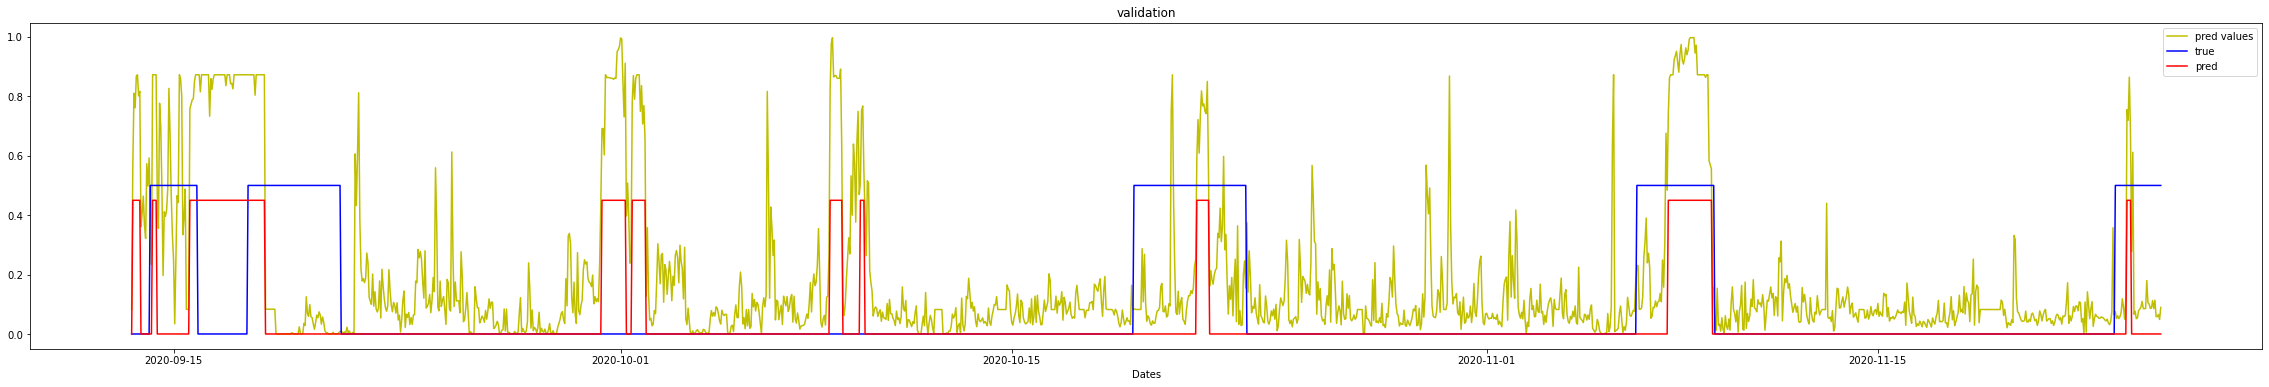

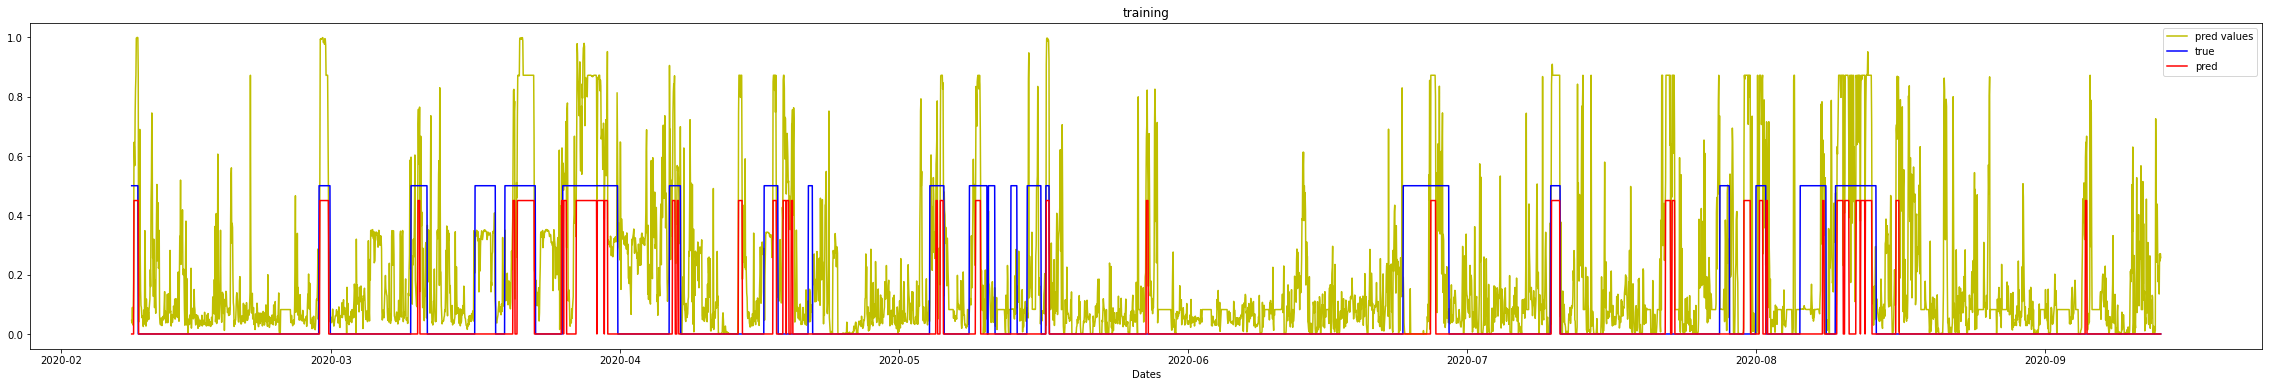

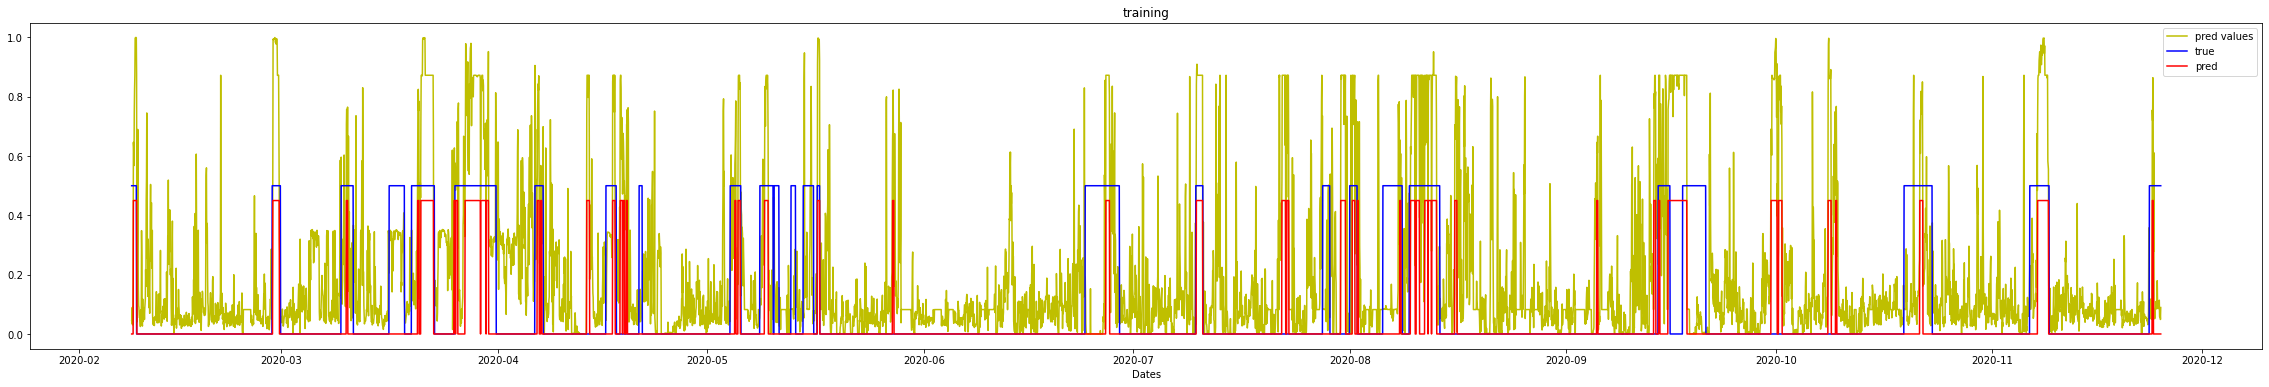

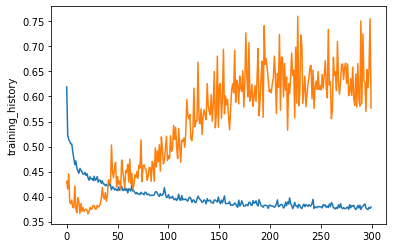

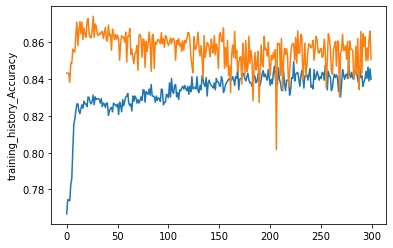

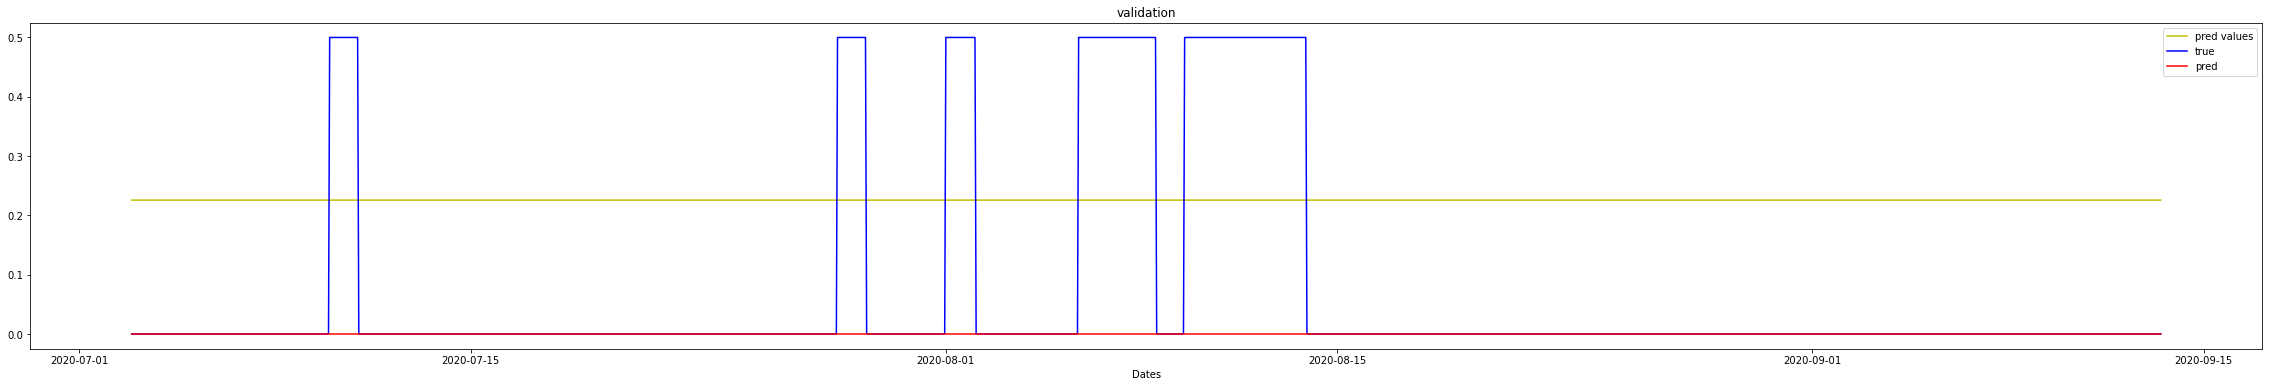

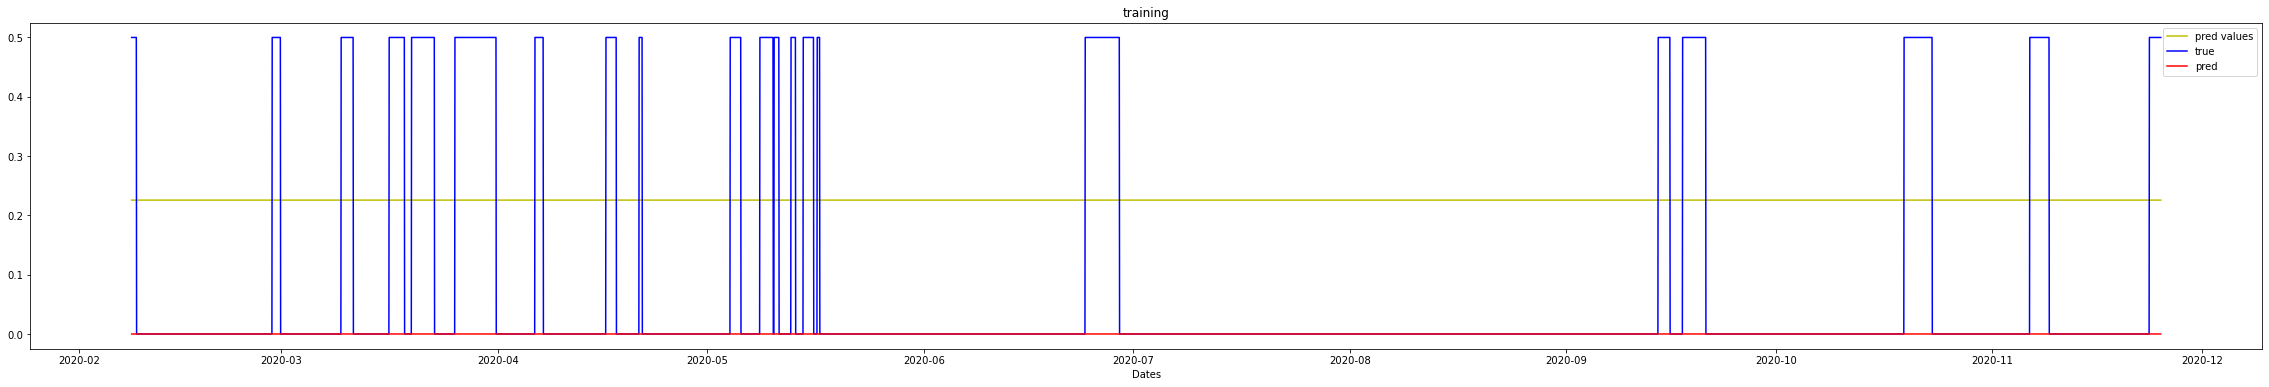

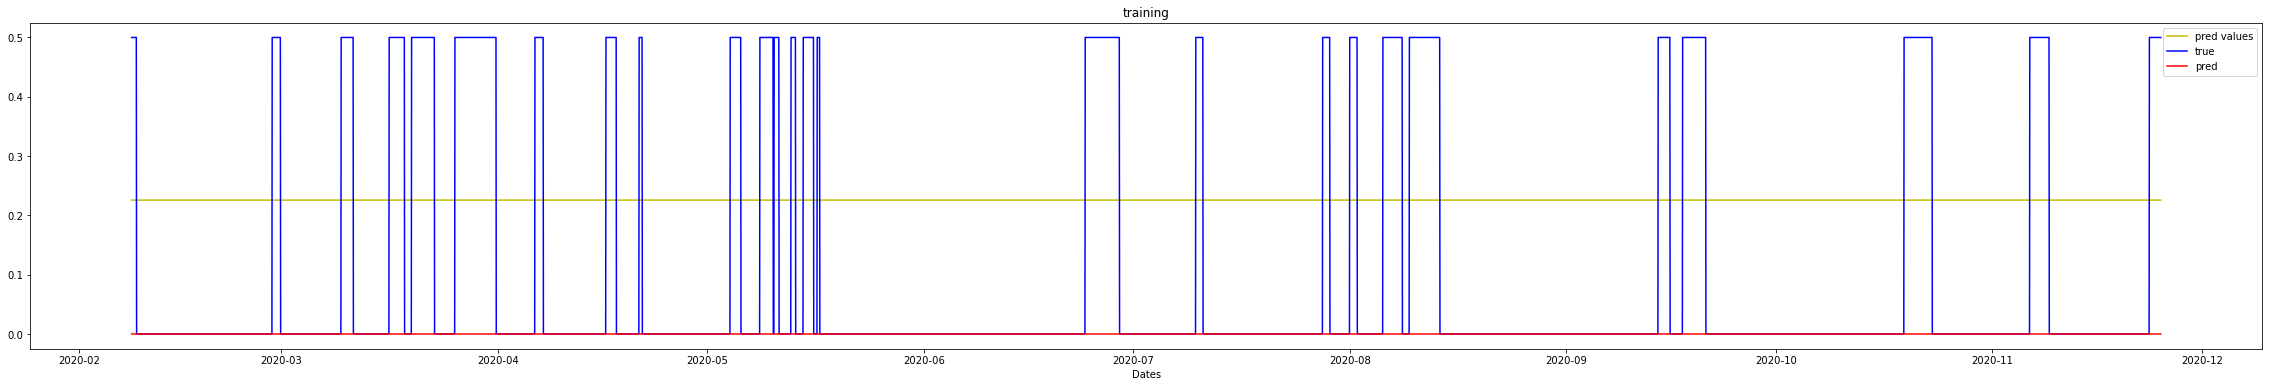

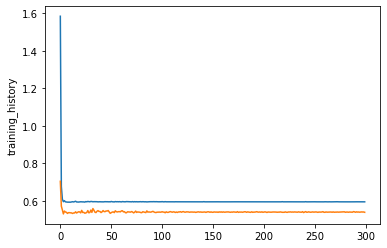

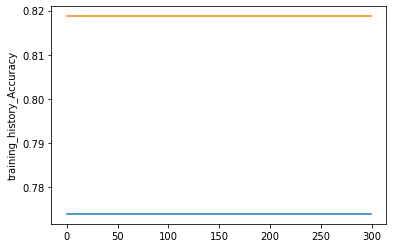

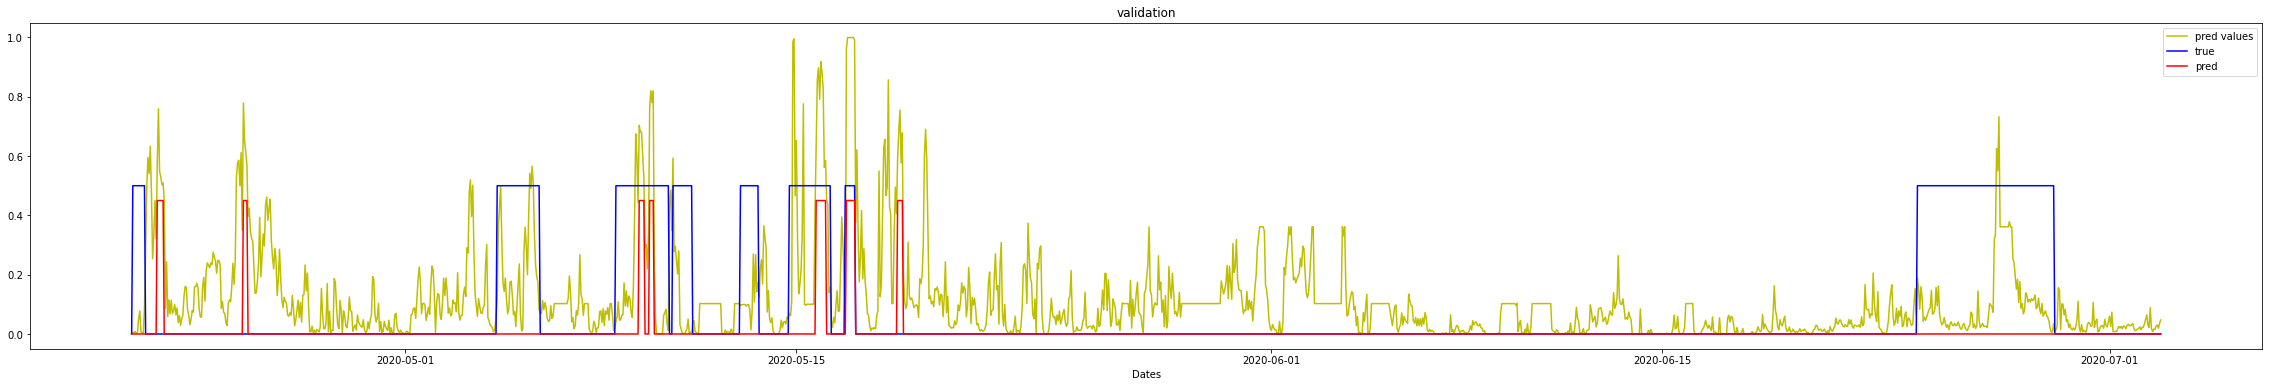

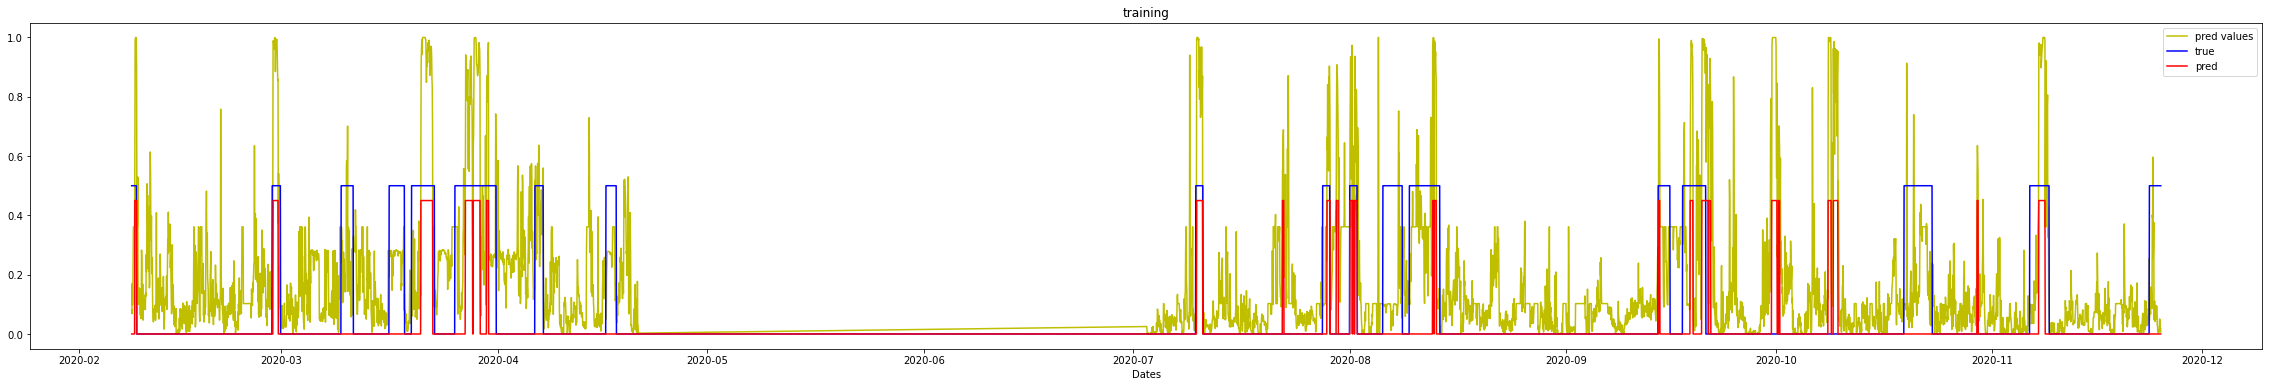

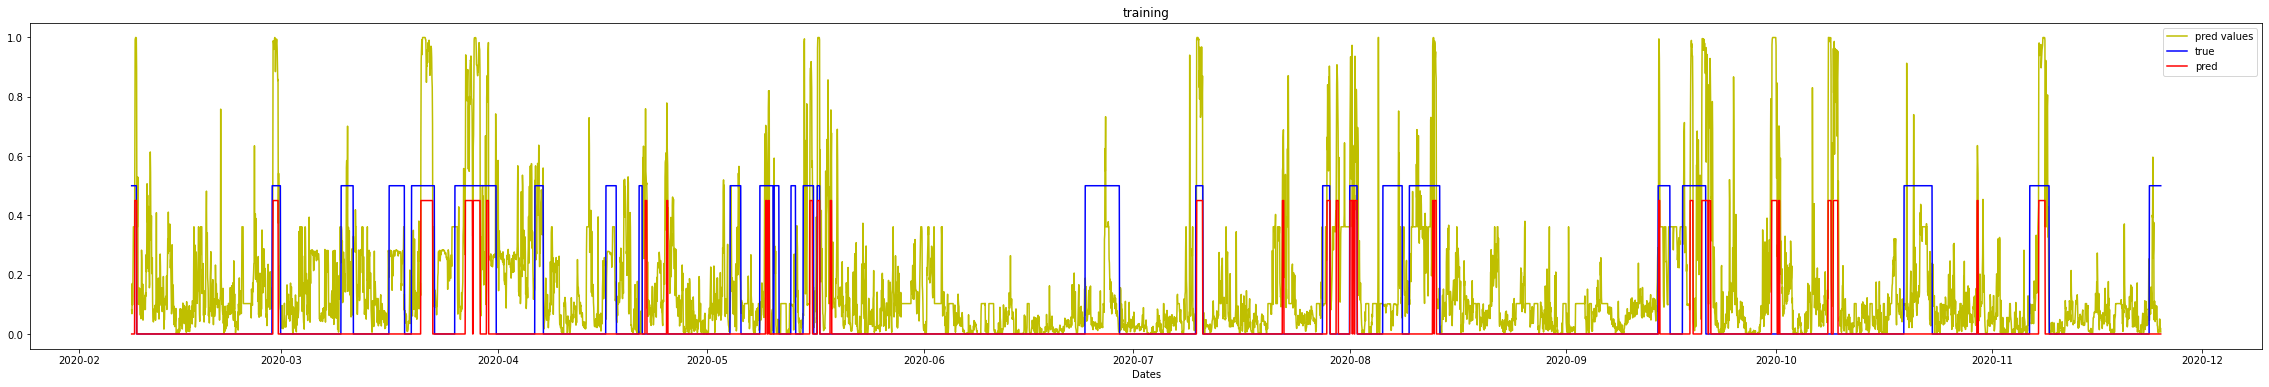

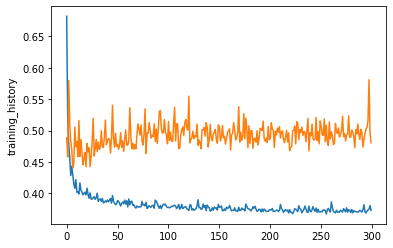

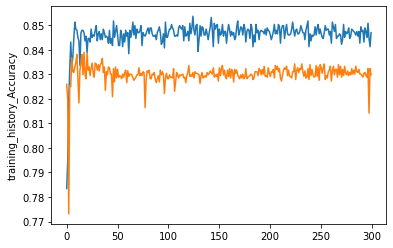

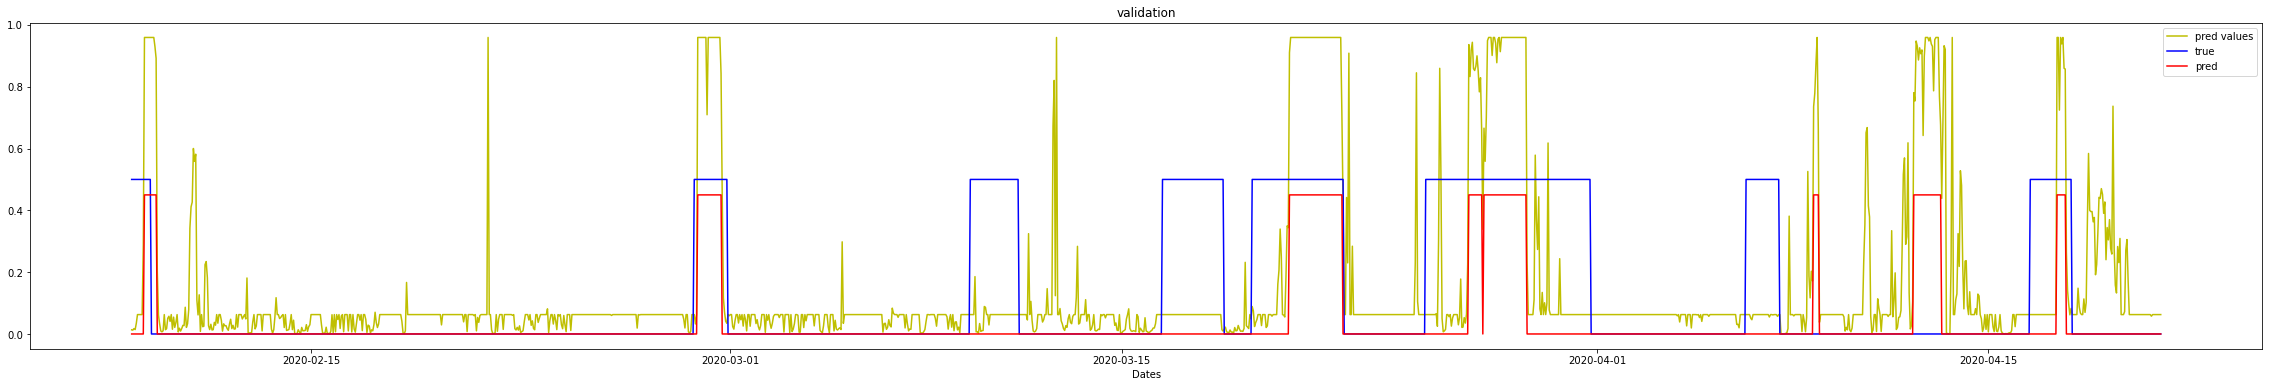

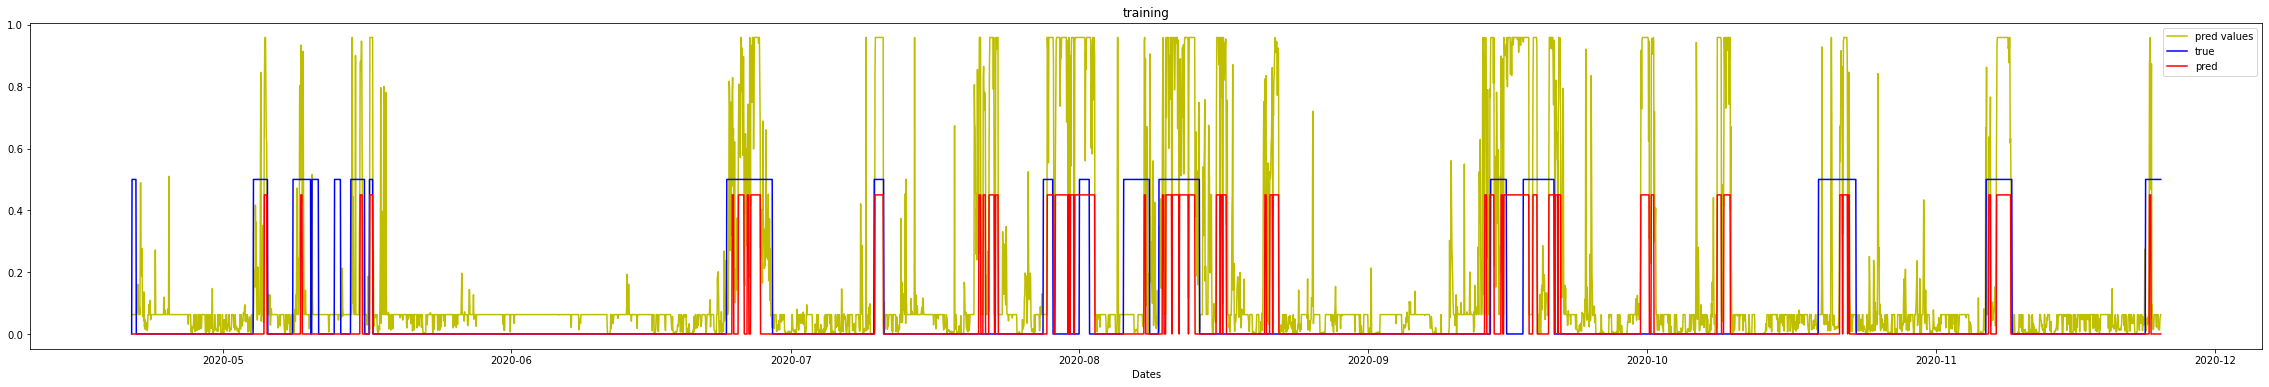

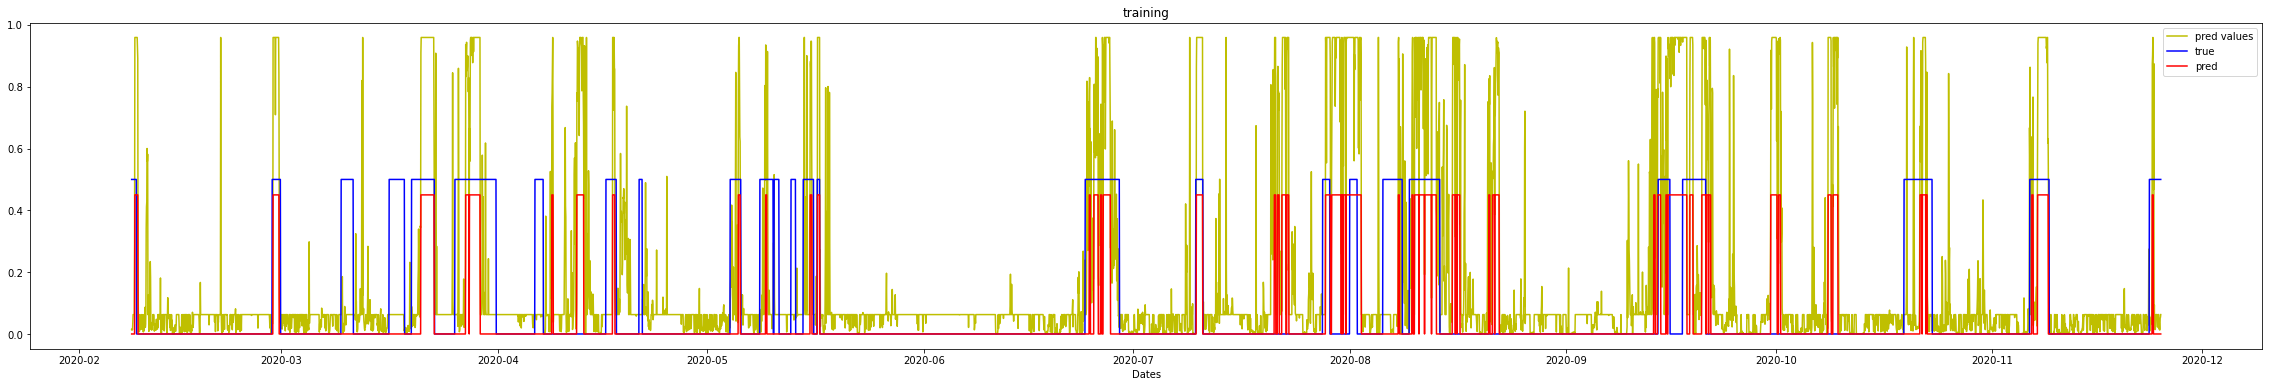

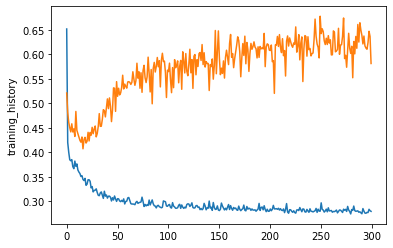

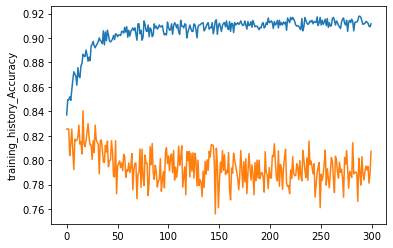

In [8]:


for index in [0,1,2,3]:
    
    print('Model: ', index)

    
    datafile_train = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/models_29_11_2022/train'+str(index)+'.h5'
    
    datafile_val = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/models_29_11_2022/val'+str(index)+'.h5'

    datafile = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/models_29_11_2022/data_all.h5'


    modelpath = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/models_06_12_2022/model0/model_'+str(index)

    
    
    df = pd.read_hdf(datafile, 'df') 
    df_output = df['sde_event']
    df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
    df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
    df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

    df_input.reset_index(drop=True, inplace=True)

    df_output.reset_index(drop=True, inplace=True)

    df_dates.reset_index(drop=True, inplace=True)
    
    dvar_train = pd.read_hdf(datafile_train,key = 'dvar')
    dvar_val = pd.read_hdf(datafile_val,key = 'dvar')
    qoi_train = pd.read_hdf(datafile_train,key = 'qoi')
    qoi_val = pd.read_hdf(datafile_val,key = 'qoi')
    dates_train = pd.read_hdf(datafile_train,key = 'dates')
    dates_val = pd.read_hdf(datafile_val,key = 'dates')    
    history1=np.load(modelpath+'/my_history.npy',allow_pickle='TRUE').item()
    surr1 = keras.models.load_model(modelpath)
    # APPLY PREPROCESSING

    qoi_min = np.min(qoi_train, axis = 0)
    qoi_max = np.max(qoi_train, axis = 0)
    dvar_min = np.min(dvar_train, axis = 0)
    dvar_max = np.max(dvar_train, axis = 0)
    dvar_train_scaled = scaling(dvar_train, dvar_min, dvar_max, scale_min, scale_max)
    dvar_val_scaled = scaling(dvar_val, dvar_min, dvar_max, scale_min, scale_max)
    dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)
    
    # USE TRAINED NETWORKS FOR PREDICTION
    qoi_val_pred = surr1.predict(np.asarray(dvar_val_scaled.values).astype('float32'))
    qoi_train_pred = surr1.predict(np.asarray(dvar_train_scaled.values).astype('float32'))
    qoi_df_pred = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
    
    qoi_val_pred = pd.DataFrame(qoi_val_pred, columns = ['sde_event'])
    qoi_train_pred = pd.DataFrame(qoi_train_pred, columns = ['sde_event'])
    
    qoi_df_pred = pd.DataFrame(qoi_df_pred, columns = ['sde_event'])
   
    qoi_train_pred = compute_dust_events(qoi_train_pred)
    qoi_val_pred = compute_dust_events(qoi_val_pred)
    qoi_df_pred = compute_dust_events(qoi_df_pred)
    
    dates_val = number_noevents_dates(dates_val, 'sde_event_nr', 'nosde_event_nr')
    dates_train = number_noevents_dates(dates_train, 'sde_event_nr', 'nosde_event_nr')
    df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
    qoi_val_pred = number_noevents_data(qoi_val_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_train_pred = number_noevents_data(qoi_train_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_df_pred = number_noevents_data(qoi_df_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

    
    
    print('Validation')
    result_val = metric_sde(dates_val, qoi_val_pred)
    print(result_val)
    result_val_acc = acc_prec_rec(result_val[4],result_val[5], result_val[6], result_val[7])
    
    print('Training')
    result_train = metric_sde(dates_train, qoi_train_pred)
    result_train_acc = acc_prec_rec(result_train[4],result_train[5], result_train[6], result_train[7])

    print('Whole dataframe')
    result_df = metric_sde(df_dates, qoi_df_pred)
    result_df_acc = acc_prec_rec(result_df[4],result_df[5], result_df[6], result_df[7])
    
    val_result = np.concatenate((result_val,np.array(result_val_acc[0:5])), axis =0)
    train_result = np.concatenate((result_train,np.array(result_train_acc[0:5])), axis =0)
    df_result = np.concatenate((result_df,np.array(result_df_acc[0:5])), axis =0)

    df_results['val_'+str(index)]= val_result
    df_results['train_'+str(index)] = train_result
    df_results['df_'+str(index)] = df_result
    df_results.rename(index = rowdict, inplace=True)
    df_results    
    
    
    
    
    
    # PLOT THE PREDICTIONS
    plt.figure(figsize = (40,6))
    plt.plot(dates_val['Dates'],qoi_val_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_val['Dates'],qoi_val['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_val['Dates'],(qoi_val_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.xlabel('Dates')
    plt.title('validation')
    plt.legend()

    plt.figure(figsize = (40,6))
    plt.plot(dates_train['Dates'],qoi_train_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_train['Dates'],qoi_train['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_train['Dates'],(qoi_train_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates') 
    plt.legend()
    
    plt.figure(figsize = (40,6))
    plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
    plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

    plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates')
    plt.legend()
    
    
    plt.figure()
    plt.plot(history1['loss'])
    plt.plot(history1['val_loss'])
    plt.ylabel('training_history')
    
    plt.figure()
    plt.plot(history1['accuracy'])
    plt.plot(history1['val_accuracy'])
    plt.ylabel('training_history_Accuracy')

In [9]:
qoi_df_pred['Ssde'] = 0*qoi_df_pred['sde_event']
qoi_df_pred['wsde']= 0*qoi_df_pred['sde_event']

In [10]:
for ind in qoi_df_pred.index:
    if qoi_df_pred['sde_event_predicted'].loc[ind]==1.0:
        if qoi_df_pred['sde_event'].loc[ind]>0.75:
            print(ind)
            print('test')
            qoi_df_pred['Ssde'].loc[ind]=1.0
        elif qoi_df_pred['sde_event'].loc[ind]>0.5 and qoi_df_pred['sde_event'].loc[ind]<=0.75:
            qoi_df_pred['wsde'].loc[ind] = 1.0
            print(ind)
            print('te')

11
test
12
test
13
test
14
test
15
test
16
test
17
test
18
test
19
test
20
test
21
test
486
test
487
test
488
test
489
test
490
test
491
test
492
test
493
test
494
te
495
test
496
test
497
test
498
test
499
test
500
test
501
test
502
test
503
test
504
test
505
test
506
test
994
test
995
test
996
test
997
test
998
test
999
test
1000
test
1001
test
1002
test
1003
test
1004
test
1005
test
1006
test
1007
test
1008
test
1009
test
1010
test
1011
test
1012
test
1013
test
1014
test
1015
test
1016
test
1017
test
1018
test
1019
test
1020
test
1021
test
1022
test
1023
test
1024
test
1025
test
1026
test
1027
test
1028
test
1029
test
1030
test
1031
test
1032
test
1033
test
1034
test
1035
test
1036
test
1037
test
1038
test
1039
te
1148
test
1149
test
1150
test
1151
test
1152
test
1153
test
1154
test
1155
test
1156
test
1157
test
1158

/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



test
1159
te
1161
te
1162
te
1163
te
1164
test
1165
test
1166
test
1167
test
1168
test
1169
test
1170
test
1171
test
1172
test
1173
test
1174
test
1175
test
1176
test
1177
test
1178
test
1179
test
1180
test
1181
test
1182
test
1183
test
1184
test
1185
test
1186
test
1187
test
1188
test
1189
test
1190
test
1191
test
1192
test
1193
test
1194
test
1195
test
1196
test
1197
test
1444
te
1445
test
1446
test
1447
test
1448
te
1530
test
1531
test
1532
test
1533
test
1534
test
1535
test
1536
test
1537
test
1538
te
1539
test
1540
test
1541
test
1542
test
1543
test
1544
test
1545
test
1546
test
1547
test
1548
test
1549
test
1550
test
1551
test
1552
test
1553
te
1653
test
1654
test
1655
te
1656
test
1657
test
1658
test
1659
test
1660
test
2085
test
2086
test
2087
test
2088
test
2089
test
2090
te
2091
te
2179
test
2180
test
2181
test
2182
te
2332
test
2333
test
2334
test
2335
test
2336
test
2337
te
2357
test
2358
test
2359
test
2360
test
2361
test
2362
test
2363
test
2364
test
3291
test
3292
test


In [11]:
qoi_df_pred.describe()

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
count  6.974000e+03          6974.000000               6974.000000   
mean   1.688070e-01             0.112848                 20.963722   
std    2.838226e-01             0.316429                 19.340562   
min    8.134142e-12             0.000000                  0.000000   
25%    3.476647e-02             0.000000                  3.000000   
50%    6.272681e-02             0.000000                 13.000000   
75%    6.272681e-02             0.000000                 39.000000   
max    9.593536e-01             1.000000                 57.000000   

       sde_event_predicted_nr         Ssde         wsde  
count             6974.000000  6974.000000  6974.000000  
mean                 3.078864     0.098079     0.014769  
std                 10.272011     0.297442     0.120636  
min                  0.000000     0.000000     0.000000  
25%                  0.000000     0.000000     0.000000  
50%                  0.000000     0.000000     0.000000  
75%                  0.000000     0.000000     0.000000  
max                 56.000000     1.000000     1.000000

<AxesSubplot:>

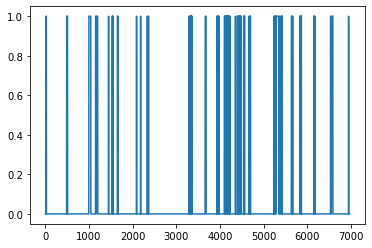

In [12]:
qoi_df_pred['Ssde'].plot()

In [ ]:
 # PLOT THE PREDICTIONS

plt.figure(figsize = (30,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event'],'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.75),'r', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['Ssde']*0.5),'m', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['wsde']*0.25),'c', label = 'pred')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20)



In [ ]:
 # PLOT THE PREDICTIONS

plt.figure(figsize = (30,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20)



In [ ]:
plt.figure()
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.ylabel('training_history')

In [ ]:
    plt.figure()
    plt.plot(history1['accuracy'])
    plt.plot(history1['val_accuracy'])
    plt.ylabel('training_history')

In [ ]:
history1

In [ ]:
df_results.columns

In [ ]:
val_col = [x for x in df_results.columns if 'val' in x]
train_col = [x for x in df_results.columns if 'train' in x]
df_col = [x for x in df_results.columns if 'df' in x]
val_col

In [ ]:
df_col

In [ ]:
df_results['average_val']=df_results[val_col].mean(axis =1)
df_results['average_train']=df_results[train_col].mean(axis =1)
df_results['average_df']=df_results[df_col].mean(axis =1)



In [ ]:
df_results['std_val']=df_results[val_col].std(axis =1)
df_results['std_train']=df_results[train_col].std(axis =1)
df_results['std_df']=df_results[df_col].std(axis =1)



In [ ]:
df_results

In [ ]:
df_results[df_col]

In [ ]:
df_results[val_col].loc['accuracy']

In [ ]:
df_results[val_col].loc['accuracy']

In [ ]:
surr1.summary()

In [ ]:

datafile = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/data/data.h5'

modelpath0 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model0'
modelpath1 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model1'
modelpath2 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model2'
modelpath3 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model3'
modelpath4 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model4'
modelpath5 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model5'
modelpath6 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model6'
modelpath7 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model7'
modelpath8 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model8'
modelpath9 = '/Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/models/model9'








df = pd.read_hdf(datafile, 'df') 
df_output = df['sde_event']
df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

df_input.reset_index(drop=True, inplace=True)

df_output.reset_index(drop=True, inplace=True)

df_dates.reset_index(drop=True, inplace=True)

surr0 = keras.models.load_model(modelpath0)
surr1 = keras.models.load_model(modelpath1)    
surr2 = keras.models.load_model(modelpath2)    
surr3 = keras.models.load_model(modelpath3)    
surr4 = keras.models.load_model(modelpath4)
surr5 = keras.models.load_model(modelpath5)
surr6 = keras.models.load_model(modelpath6) 
surr7 = keras.models.load_model(modelpath7)
surr8 = keras.models.load_model(modelpath8)   
surr9 = keras.models.load_model(modelpath9) 
# APPLY PREPROCESSING

qoi_min = np.min(qoi_train, axis = 0)
qoi_max = np.max(qoi_train, axis = 0)
dvar_min = np.min(dvar_train, axis = 0)
dvar_max = np.max(dvar_train, axis = 0)
dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)

# USE TRAINED NETWORKS FOR PREDICTION
qoi_df_pred0 = surr0.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred1 = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred2 = surr2.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred3 = surr3.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred4 = surr4.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred5 = surr5.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred6 = surr6.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred7 = surr7.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred8 = surr8.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred9 = surr9.predict(np.asarray(dvar_df_scaled.values).astype('float32'))




qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.

#qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred3+qoi_df_pred4+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/8.



qoi_df_pred_new = pd.DataFrame(qoi_df_pred_new, columns = ['sde_event'])

qoi_df_pred_new = compute_dust_events(qoi_df_pred_new)

df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
qoi_df_pred_new = number_noevents_data(qoi_df_pred_new, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

'''
qoi_df_pred0 = pd.DataFrame(qoi_df_pred0, columns = ['sde_event'])
qoi_df_pred0 = compute_dust_events(qoi_df_pred0)
qoi_df_pred0 = number_noevents_data(qoi_df_pred0, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred1 = pd.DataFrame(qoi_df_pred1, columns = ['sde_event'])
qoi_df_pred1 = compute_dust_events(qoi_df_pred1)
qoi_df_pred1 = number_noevents_data(qoi_df_pred1, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred2 = pd.DataFrame(qoi_df_pred2, columns = ['sde_event'])
qoi_df_pred2 = compute_dust_events(qoi_df_pred2)
qoi_df_pred2 = number_noevents_data(qoi_df_pred2, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred3 = pd.DataFrame(qoi_df_pred3, columns = ['sde_event'])
qoi_df_pred3 = compute_dust_events(qoi_df_pred3)
qoi_df_pred3 = number_noevents_data(qoi_df_pred3, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred4 = pd.DataFrame(qoi_df_pred4, columns = ['sde_event'])
qoi_df_pred4 = compute_dust_events(qoi_df_pred4)
qoi_df_pred4 = number_noevents_data(qoi_df_pred4, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred5 = pd.DataFrame(qoi_df_pred5, columns = ['sde_event'])
qoi_df_pred5 = compute_dust_events(qoi_df_pred5)
qoi_df_pred5 = number_noevents_data(qoi_df_pred5, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred6 = pd.DataFrame(qoi_df_pred6, columns = ['sde_event'])
qoi_df_pred6 = compute_dust_events(qoi_df_pred6)
qoi_df_pred6 = number_noevents_data(qoi_df_pred6, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred7 = pd.DataFrame(qoi_df_pred7, columns = ['sde_event'])
qoi_df_pred7 = compute_dust_events(qoi_df_pred7)
qoi_df_pred7 = number_noevents_data(qoi_df_pred7, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred8 = pd.DataFrame(qoi_df_pred8, columns = ['sde_event'])
qoi_df_pred8 = compute_dust_events(qoi_df_pred8)
qoi_df_pred8 = number_noevents_data(qoi_df_pred8, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred9 = pd.DataFrame(qoi_df_pred9, columns = ['sde_event'])
qoi_df_pred9 = compute_dust_events(qoi_df_pred9)
qoi_df_pred9 = number_noevents_data(qoi_df_pred9, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')


qoi_df_pred_new_test = qoi_df_pred_new.copy()
qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.
'''




print('Whole dataframe')
result_df_new = metric_sde(df_dates, qoi_df_pred_new)
result_df_acc_new = acc_prec_rec(result_df_new[4],result_df_new[5], result_df_new[6], result_df_new[7])

df_result_new = np.concatenate((result_df_new,np.array(result_df_acc_new[0:5])), axis =0)

df_results['df_total'] = df_result_new
df_results.rename(index = rowdict, inplace=True)
df_results    





# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred_new['sde_event_predicted']*0.45),'r', label = 'pred')
plt.title('training')
plt.xlabel('Dates')
plt.legend()




In [ ]:
#(qoi_df_pred_new['sde_event']-qoi_df_pred_new_test['sde_event']).sum()

In [ ]:


for index in [1]:
    
    print('Model: ', index)

    
    datafile_train = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/train'+str(index)+'.h5'
   
    datafile_val = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/val'+str(index)+'.h5'

    datafile = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/data_all.h5'


    modelpath = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/model_'+str(index)


    
    
    df = pd.read_hdf(datafile, 'df') 
    df_output = df['sde_event']
    df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
    df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
    df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

    df_input.reset_index(drop=True, inplace=True)

    df_output.reset_index(drop=True, inplace=True)

    df_dates.reset_index(drop=True, inplace=True)
    
    dvar_train = pd.read_hdf(datafile_train,key = 'dvar')
    dvar_val = pd.read_hdf(datafile_val,key = 'dvar')
    qoi_train = pd.read_hdf(datafile_train,key = 'qoi')
    qoi_val = pd.read_hdf(datafile_val,key = 'qoi')
    dates_train = pd.read_hdf(datafile_train,key = 'dates')
    dates_val = pd.read_hdf(datafile_val,key = 'dates')    
    history1=np.load(modelpath+'/my_history.npy',allow_pickle='TRUE').item()
    surr1 = keras.models.load_model(modelpath)
    # APPLY PREPROCESSING

    qoi_min = np.min(qoi_train, axis = 0)
    qoi_max = np.max(qoi_train, axis = 0)
    dvar_min = np.min(dvar_train, axis = 0)
    dvar_max = np.max(dvar_train, axis = 0)
    dvar_train_scaled = scaling(dvar_train, dvar_min, dvar_max, scale_min, scale_max)
    dvar_val_scaled = scaling(dvar_val, dvar_min, dvar_max, scale_min, scale_max)
    dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)
    
    # USE TRAINED NETWORKS FOR PREDICTION
    qoi_val_pred = surr1.predict(np.asarray(dvar_val_scaled.values).astype('float32'))
    qoi_train_pred = surr1.predict(np.asarray(dvar_train_scaled.values).astype('float32'))
    qoi_df_pred = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
    
    qoi_val_pred = pd.DataFrame(qoi_val_pred, columns = ['sde_event'])
    qoi_train_pred = pd.DataFrame(qoi_train_pred, columns = ['sde_event'])
    
    qoi_df_pred = pd.DataFrame(qoi_df_pred, columns = ['sde_event'])
   
    qoi_train_pred = compute_dust_events(qoi_train_pred)
    qoi_val_pred = compute_dust_events(qoi_val_pred)
    qoi_df_pred = compute_dust_events(qoi_df_pred)
    
    dates_val = number_noevents_dates(dates_val, 'sde_event_nr', 'nosde_event_nr')
    dates_train = number_noevents_dates(dates_train, 'sde_event_nr', 'nosde_event_nr')
    df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
    qoi_val_pred = number_noevents_data(qoi_val_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_train_pred = number_noevents_data(qoi_train_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_df_pred = number_noevents_data(qoi_df_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

    
    
    print('Validation')
    result_val = metric_sde(dates_val, qoi_val_pred)
    print(result_val)
    result_val_acc = acc_prec_rec(result_val[4],result_val[5], result_val[6], result_val[7])
    
    print('Training')
    result_train = metric_sde(dates_train, qoi_train_pred)
    result_train_acc = acc_prec_rec(result_train[4],result_train[5], result_train[6], result_train[7])

    print('Whole dataframe')
    result_df = metric_sde(df_dates, qoi_df_pred)
    result_df_acc = acc_prec_rec(result_df[4],result_df[5], result_df[6], result_df[7])
    
    val_result = np.concatenate((result_val,np.array(result_val_acc[0:5])), axis =0)
    train_result = np.concatenate((result_train,np.array(result_train_acc[0:5])), axis =0)
    df_result = np.concatenate((result_df,np.array(result_df_acc[0:5])), axis =0)

    df_results['val_'+str(index)]= val_result
    df_results['train_'+str(index)] = train_result
    df_results['df_'+str(index)] = df_result
    df_results.rename(index = rowdict, inplace=True)
    df_results    
    
    
    
    
    
    # PLOT THE PREDICTIONS
    plt.figure(figsize = (40,6))
    plt.plot(dates_val['Dates'],qoi_val_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_val['Dates'],qoi_val['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_val['Dates'],(qoi_val_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.xlabel('Dates')
    plt.title('validation')
    plt.legend()

    plt.figure(figsize = (40,6))
    plt.plot(dates_train['Dates'],qoi_train_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_train['Dates'],qoi_train['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_train['Dates'],(qoi_train_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates') 
    plt.legend()
    
    plt.figure(figsize = (40,6))
    plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
    plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

    plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates')
    plt.legend()
    
    
    plt.figure()
    plt.plot(history1['loss'])
    plt.plot(history1['val_loss'])
    plt.ylabel('training_history')
    
    plt.figure()
    plt.plot(history1['accuracy'])
    plt.plot(history1['val_accuracy'])
    plt.ylabel('training_history_Accuracy')

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
ax.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred. values')
ax.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.75,'b',label = 'true SDE')

ax.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred. SDE')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20, loc ='lower left')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=5)


In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
ax.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred. values')
ax.plot(df_dates['DateTimeUTC'],df_output['sde_event'],'b',label = 'true SDE')

#ax.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred. SDE')

plt.xlabel('Dates', fontsize = 20)
plt.ylabel('Probability of event occurrence', fontsize = 20)
plt.legend(fontsize = 20, loc ='lower left')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=5)


In [ ]:
df_results[val_col]

In [ ]:
df_results[train_col]

In [ ]:
df_results[df_col]

In [ ]:
surr0.summary()

In [ ]:
surr1.summary()

In [ ]:
surr2.summary()

In [ ]:
surr3.summary()

In [ ]:
surr4.summary()

In [ ]:
surr5.summary()

In [ ]:
surr6.summary()

In [ ]:
surr7.summary()

In [ ]:
surr8.summary()

In [ ]:
surr9.summary()

In [ ]:
df_results[['df_total']]

In [ ]:
df_results

In [ ]:
df_col1 = [x for x in df_results.columns if 'df' in x]
val_col1 = [x for x in df_results.columns if 'val' in x]
train_col1 = [x for x in df_results.columns if 'train' in x]

In [ ]:
df_results[df_col1]

In [ ]:
df_results[val_col1]

In [ ]:
df_results[train_col1]

In [ ]:

qoi_df_pred0 = pd.DataFrame(qoi_df_pred0, columns = ['sde_event'])
qoi_df_pred0 = compute_dust_events(qoi_df_pred0)
qoi_df_pred0 = number_noevents_data(qoi_df_pred0, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred1 = pd.DataFrame(qoi_df_pred1, columns = ['sde_event'])
qoi_df_pred1 = compute_dust_events(qoi_df_pred1)
qoi_df_pred1 = number_noevents_data(qoi_df_pred1, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred2 = pd.DataFrame(qoi_df_pred2, columns = ['sde_event'])
qoi_df_pred2 = compute_dust_events(qoi_df_pred2)
qoi_df_pred2 = number_noevents_data(qoi_df_pred2, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred3 = pd.DataFrame(qoi_df_pred3, columns = ['sde_event'])
qoi_df_pred3 = compute_dust_events(qoi_df_pred3)
qoi_df_pred3 = number_noevents_data(qoi_df_pred3, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred4 = pd.DataFrame(qoi_df_pred4, columns = ['sde_event'])
qoi_df_pred4 = compute_dust_events(qoi_df_pred4)
qoi_df_pred4 = number_noevents_data(qoi_df_pred4, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred5 = pd.DataFrame(qoi_df_pred5, columns = ['sde_event'])
qoi_df_pred5 = compute_dust_events(qoi_df_pred5)
qoi_df_pred5 = number_noevents_data(qoi_df_pred5, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred6 = pd.DataFrame(qoi_df_pred6, columns = ['sde_event'])
qoi_df_pred6 = compute_dust_events(qoi_df_pred6)
qoi_df_pred6 = number_noevents_data(qoi_df_pred6, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred7 = pd.DataFrame(qoi_df_pred7, columns = ['sde_event'])
qoi_df_pred7 = compute_dust_events(qoi_df_pred7)
qoi_df_pred7 = number_noevents_data(qoi_df_pred7, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred8 = pd.DataFrame(qoi_df_pred8, columns = ['sde_event'])
qoi_df_pred8 = compute_dust_events(qoi_df_pred8)
qoi_df_pred8 = number_noevents_data(qoi_df_pred8, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred9 = pd.DataFrame(qoi_df_pred9, columns = ['sde_event'])
qoi_df_pred9 = compute_dust_events(qoi_df_pred9)
qoi_df_pred9 = number_noevents_data(qoi_df_pred9, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')


qoi_df_pred_new_test = qoi_df_pred_new.copy()
qoi_df_pred_new_test2 = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.




In [ ]:
qoi_df_pred_new_test2

In [ ]:
print('Whole dataframe')
result_df_new_test2 = metric_sde(df_dates, qoi_df_pred_new_test2)
result_df_acc_new_test2 = acc_prec_rec(result_df_new_test2[4],result_df_new_test2[5], result_df_new_test2[6], result_df_new_test2[7])

df_result_new_test2 = np.concatenate((result_df_new_test2,np.array(result_df_acc_new_test2[0:5])), axis =0)

df_results['df_total'] = df_result_new_test2
#df_results.rename(index = rowdict, inplace=True)
df_results    





# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred_new['sde_event_predicted']*0.45),'r', label = 'pred')
plt.title('training')
plt.xlabel('Dates')
plt.legend()





In [ ]:
qoi_df_pred0

In [ ]:
# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred0['sde_event_predicted'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred1['sde_event_predicted']*0.75,'g',label='pred values')

plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event_predicted']*1.25,'m',label='pred values')

plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new_test2['sde_event_predicted']*1.35,'k',label='pred values')


plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*1.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred2['sde_event_predicted']*0.5),'r', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred3['sde_event_predicted']*0.25),'k', label = 'pred')


plt.title('training')
plt.xlabel('Dates')
plt.legend()




